## Long Short-Term Memory (LSTM)
The LSTM Model is only run on the preprocessed data

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [42]:
def df_to_dataset(dataframe, column, shuffle=True, batch_size=64):
    """Convert the Pandas' dataset into a tensorflow dataset and shuffle and batch the entries."""
    df = dataframe.copy()
    code = df.pop('code')
    df = dataframe[f'{column}']
    ds = tf.data.Dataset.from_tensor_slices((df, code))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

### Dataset with normal sentences

In [43]:
df = pd.read_json('..\\06_data_prep.json')
df.sector = pd.Categorical(df.sector)
df['code'] = df.sector.cat.codes
df.head()

,description,sector,code
0,Adara Acquisition Corp. does not have signific...,Financial Services,5
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,6
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,5
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,1
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,3


In [44]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [45]:
column = 'description'

train_data = df_to_dataset(train, column)
valid_data = df_to_dataset(val, column)
test_data = df_to_dataset(test, column)

In [47]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [48]:
# [UNK] is for unknown tokens
vocab = np.array(encoder.get_vocabulary())
vocab[:5]

array(['', '[UNK]', 'and', 'the', 'in'], dtype='<U18')

In [49]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32, mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(11, activation='softmax')
])

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# es = EarlyStopping(patience=4, verbose=1, restore_best_weights=True)

In [51]:
# train the model and use early stopping
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=20,
                    # callbacks=[es]
                    )

Epoch 1/20
123/123 [==============================] - 11s 71ms/step - loss: 2.3493 - accuracy: 0.2519 - val_loss: 2.2564 - val_accuracy: 0.1700
Epoch 2/20
123/123 [==============================] - 8s 68ms/step - loss: 2.0602 - accuracy: 0.3174 - val_loss: 2.2044 - val_accuracy: 0.1700
Epoch 3/20
123/123 [==============================] - 8s 66ms/step - loss: 1.7665 - accuracy: 0.4105 - val_loss: 1.9273 - val_accuracy: 0.3036
Epoch 4/20
123/123 [==============================] - 8s 67ms/step - loss: 1.5009 - accuracy: 0.4811 - val_loss: 1.7684 - val_accuracy: 0.3745
Epoch 5/20
123/123 [==============================] - 8s 66ms/step - loss: 1.4268 - accuracy: 0.5181 - val_loss: 1.7114 - val_accuracy: 0.3998
Epoch 6/20
123/123 [==============================] - 8s 65ms/step - loss: 1.4127 - accuracy: 0.5038 - val_loss: 1.7246 - val_accuracy: 0.3512
Epoch 7/20
123/123 [==============================] - 8s 68ms/step - loss: 1.3885 - accuracy: 0.5228 - val_loss: 1.6716 - val_accuracy: 0.443

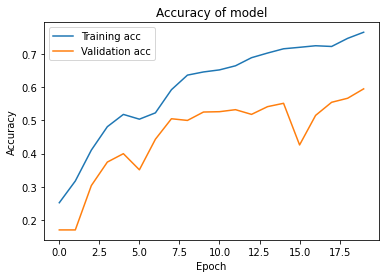

In [52]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

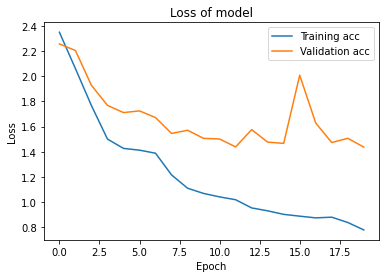

In [53]:
plt.plot(history.history['loss'], label="Training acc")
plt.plot(history.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [54]:
model.evaluate(test_data)

16/16 [==============================] - 0s 21ms/step - loss: 1.3218 - accuracy: 0.6191


[1.3217673301696777, 0.6191446185112]

### Dataset without stopwords and lemmatization

In [31]:
column = 'explicit_lemmatization'

df = pd.read_json('..\\Unternehmen_preprocessed.json')
df = df[['explicit_lemmatization', 'sector']]
df.sector = pd.Categorical(df.sector)
df['code'] = df.sector.cat.codes
df.head()

,explicit_lemmatization,sector,code
0,significant operation company intend effect me...,Financial Services,5
1,immuno pharma company focus research developme...,Healthcare,6
2,Ashford Inc asset management firm firm provide...,Financial Services,5
3,subsidiary operate digital medium platform Uni...,Communication Services,1
4,subsidiary engage wholesale distribution consu...,Consumer Defensive,3


In [34]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [35]:
train_data = df_to_dataset(train, column)
valid_data = df_to_dataset(val, column)
test_data = df_to_dataset(test, column)

In [19]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [20]:
model_lemma = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32, mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(11, activation='softmax')
])

In [21]:
model_lemma.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# es = EarlyStopping(patience=4, verbose=1, restore_best_weights=True)

In [22]:
# train the model and use early stopping
history_lemma = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=20,
                    # callbacks=[es]
                    )

Epoch 1/20
123/123 [==============================] - 5s 44ms/step - loss: 2.4428 - accuracy: 0.2322 - val_loss: 2.1496 - val_accuracy: 0.2665
Epoch 2/20
123/123 [==============================] - 5s 43ms/step - loss: 2.1796 - accuracy: 0.2548 - val_loss: 2.1409 - val_accuracy: 0.2472
Epoch 3/20
123/123 [==============================] - 5s 43ms/step - loss: 2.1282 - accuracy: 0.2653 - val_loss: 2.0779 - val_accuracy: 0.2705
Epoch 4/20
123/123 [==============================] - 5s 43ms/step - loss: 2.0498 - accuracy: 0.2950 - val_loss: 2.0442 - val_accuracy: 0.2725
Epoch 5/20
123/123 [==============================] - 5s 43ms/step - loss: 1.9758 - accuracy: 0.3280 - val_loss: 1.9845 - val_accuracy: 0.2918
Epoch 6/20
123/123 [==============================] - 5s 43ms/step - loss: 1.9573 - accuracy: 0.3272 - val_loss: 1.9510 - val_accuracy: 0.2989
Epoch 7/20
123/123 [==============================] - 5s 43ms/step - loss: 1.9296 - accuracy: 0.3416 - val_loss: 1.9427 - val_accuracy: 0.3141

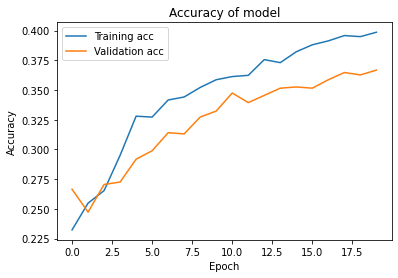

In [23]:
plt.plot(history_lemma.history['accuracy'], label="Training acc")
plt.plot(history_lemma.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

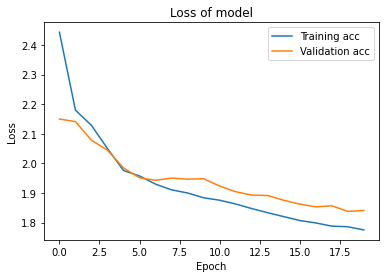

In [24]:
plt.plot(history_lemma.history['loss'], label="Training acc")
plt.plot(history_lemma.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [25]:
model_lemma.evaluate(test_data)

16/16 [==============================] - 1s 13ms/step - loss: 2.7177 - accuracy: 0.0866


[2.717738389968872, 0.08664628118276596]